# Objection Detection using YOLO v3

### YOLO v3 (You only look once) implemented in TensorFlow

In [1]:
#import libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from yolov3 import *
from util import *

from PIL import Image, ImageDraw, ImageFont
import cv2

In [2]:
#From YOLOv3 paper https://pjreddie.com/media/files/papers/YOLOv3.pdf, bounding box priors
#dervived using k-means clustering on COCO dataset
ANCHORS = [(10,13),(16,30),(33,23),(30,61),(62,45),(59,119),(116,90),(156,198),(373,326)]


## Converting Official YOLO v3 weights to Tensorflow format
#### Official YOLO v3 weights trained on COCO dataset

In [ ]:
"""
inputs = tf.placeholder(tf.float32, [1, 416, 416, 3])

model = YOLOv3((416,416), 80, ANCHORS, 0.4, 0.5, 20, 'channels_last')
detect_model = model.detect(inputs)

yolovars = tf.global_variables(scope='yolov3')
assign_list = convert_weights(yolovars, './Data/yolov3.weights')

saver = tf.train.Saver(tf.global_variables(scope='yolov3'))

with tf.Session() as sess:
    sess.run(assign_list)
    saver.save(sess, './Data/yolov3.ckpt')
"""

# Sample Detections

In [ ]:
inputs = tf.placeholder(tf.float32, [3, 416, 416, 3])

file_list = ['./Data/test.jpg', './Data/test2.jpg', './Data/dog.jpg']
batch = load_image_batch(file_list, (416,416))
classnames = class_names('./Data/coco.names')

model = YOLOv3((416,416), 80, ANCHORS, 0.5, 0.5, 5, 'channels_last')
detect_model = model.detect(inputs)
saver = tf.train.Saver(tf.global_variables(scope='yolov3'))

with tf.Session() as sess:
    #writer = tf.summary.FileWriter('logs', sess.graph)
    saver.restore(sess, './Data/yolov3.ckpt')
    detection_result = sess.run(detect_model, feed_dict={inputs: batch})
    #writer.close()

# Output
#### YOLO v3 outputs a prediction tensor of N x N x 3 * (4 + 1 + number of classes) 

in which the last dimension is detection at 3 different scales * (4 box coordinates (box center x, box center y, box width, box height) + 1 confidence score + 80 class prediction scores.

The box coordinates are then to converted box diagonal coordinates for IOU (Intersection over Union) during Non-Max Suppression. Final output is a list of class $\rightarrow$ boxes dictionaries (as shown below)

In [ ]:
detection_result

In [ ]:
for i, filename in enumerate(file_list):
    draw_boxes(filename, classnames, detection_result[i], (416,416))

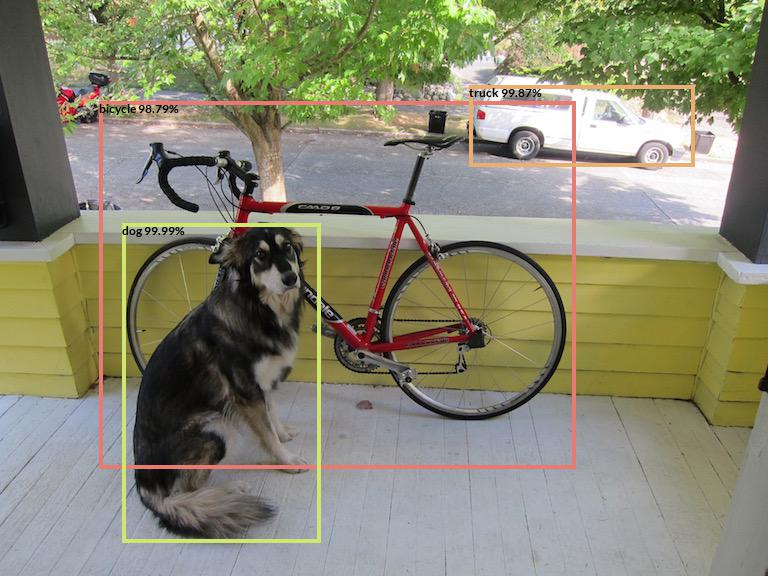

In [4]:
from IPython.display import Image 
Image(filename='./output/detection_dog.jpg')

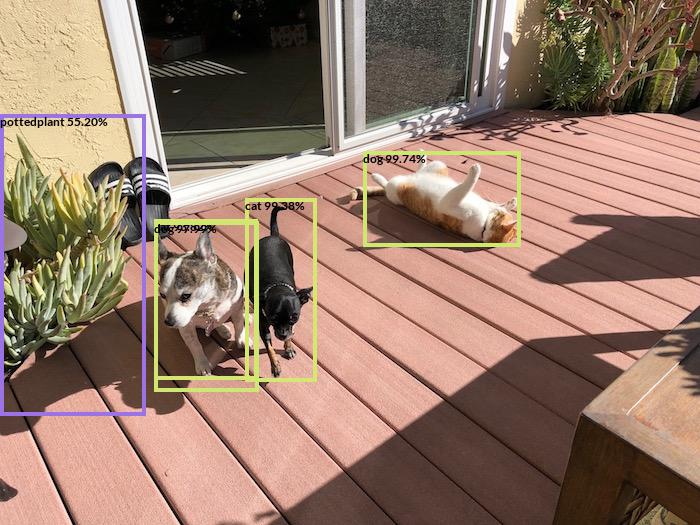

In [5]:
Image(filename='./output/detection_test.jpg')

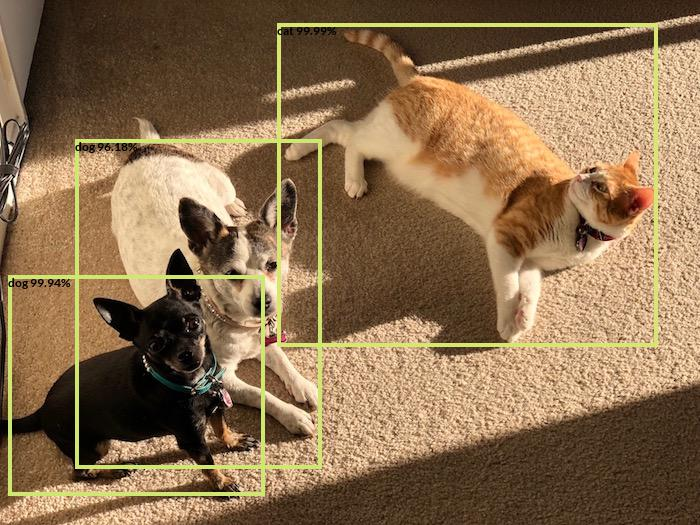

In [6]:
Image(filename='./output/detection_test2.jpg')

## Processing Video Example

The video processing runs really slow on my 2009 MacBook Pro so I had to drop the model input size from (416,416) to (208,208) speed things up for this test. Detection accuracy defintely suffered from it. Eventually, i'll separate some of the frame processing on different threads to improve performance.  

In [ ]:
inputs = tf.placeholder(tf.float32, [1, 208, 208, 3])
classnames = class_names('./Data/coco.names')

model = YOLOv3((208,208), 80, ANCHORS, 0.5, 0.5, 10, 'channels_last')
detect_model = model.detect(inputs)
saver = tf.train.Saver(tf.global_variables(scope='yolov3'))

with tf.Session() as sess:
    saver.restore(sess, './Data/yolov3.ckpt')
    
    cap = cv2.VideoCapture('./Data/360p_video.mp4')
    frame_size = (cap.get(cv2.CAP_PROP_FRAME_WIDTH), cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*'MJPG')
    fps = cap.get(cv2.CAP_PROP_FPS)
    out = cv2.VideoWriter('./output/detection_360p.avi', fourcc, 15,
                                  (int(frame_size[0]), int(frame_size[1])))
    i=0
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            resized_frame = cv2.resize(frame, dsize=(208,208), interpolation=cv2.INTER_NEAREST)
            detection_result = sess.run(detect_model, feed_dict={inputs: [resized_frame]})
            
            draw_boxes_video(frame, classnames, detection_result[0], frame_size, (208,208))
        
            out.write(frame)

            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
            i+=1
            print("Frame",i)
    finally:
            print("Task Completed")
            cv2.destroyAllWindows()
            cap.release()

#### Here's a small segment of the video test

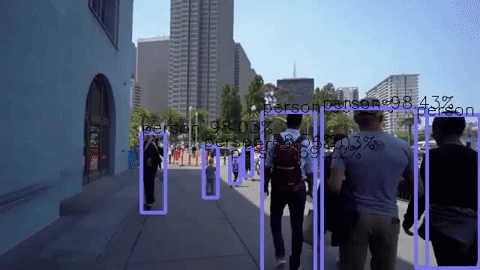

In [7]:
Image(filename='./output/video_test.gif')